# <b>CS156 (Introduction to AI), Spring 2022</b>
# <u><b>Homework 8 submission</b></u>

### Roster Name: Bernard Tan
### Preferred Name (if different): Bernard
### Student ID: 015215317
### Email address: bernard.tan@sjsu.edu
Any special notes or anything you would like to communicate to me about this homework submission goes in here.

##  <u>References and sources </u>

List all your references and sources here.
This includes all sites/discussion boards/blogs/posts/etc. where you grabbed some code examples.

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

In [ ]:
np.random.seed(42)

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/training",
    validation_split=0.2,
    subset="training",
    seed=42,
    
    labels='inferred',
    label_mode='categorical',
    
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/training",
    validation_split=0.2,
    subset="validation",
    seed=42,
    
    labels='inferred',
    label_mode='categorical',
    
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/test",
    seed=42,
    
    labels='inferred',
    label_mode='categorical',
    
    image_size=image_size,
    batch_size=1,
)


Found 3456 files belonging to 5 classes.
Using 2765 files for training.
Found 3456 files belonging to 5 classes.
Using 691 files for validation.
Found 861 files belonging to 5 classes.


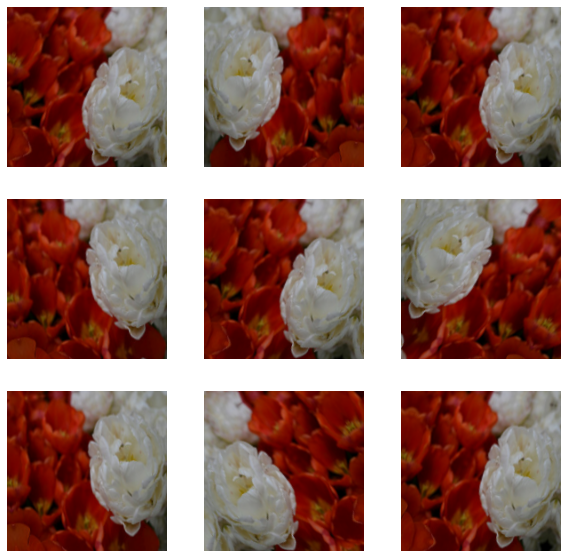

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
______________________________________________________________________________________________

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
87/87 [==============================] - 262s 3s/step - loss: 1.2626 - accuracy: 0.5342 - val_loss: 1.6518 - val_accuracy: 0.2590
Epoch 2/20


/Users/nicholas_dave/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


87/87 [==============================] - 268s 3s/step - loss: 1.0034 - accuracy: 0.6253 - val_loss: 2.1815 - val_accuracy: 0.2590
Epoch 3/20
87/87 [==============================] - 262s 3s/step - loss: 0.8878 - accuracy: 0.6723 - val_loss: 2.8069 - val_accuracy: 0.2590
Epoch 4/20
87/87 [==============================] - 263s 3s/step - loss: 0.8245 - accuracy: 0.6890 - val_loss: 3.0741 - val_accuracy: 0.2590
Epoch 5/20
87/87 [==============================] - 262s 3s/step - loss: 0.7971 - accuracy: 0.7016 - val_loss: 3.2580 - val_accuracy: 0.2590
Epoch 6/20
87/87 [==============================] - 264s 3s/step - loss: 0.7587 - accuracy: 0.7226 - val_loss: 1.9908 - val_accuracy: 0.4052
Epoch 7/20
87/87 [==============================] - 254s 3s/step - loss: 0.6805 - accuracy: 0.7392 - val_loss: 1.1884 - val_accuracy: 0.5818
Epoch 8/20
87/87 [==============================] - 257s 3s/step - loss: 0.6724 - accuracy: 0.7552 - val_loss: 1.2271 - val_accuracy: 0.5687
Epoch 9/20
87/87 [======

In [ ]:
true_labels = []
predicted_labels = []
#x = image, y = label
for x, y in test_ds:
    pred = model.predict(x)
    true_labels.append(np.where(y == 1.)[1][0])
    predicted_labels.append(np.where(pred == np.amax(pred))[1][0])

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

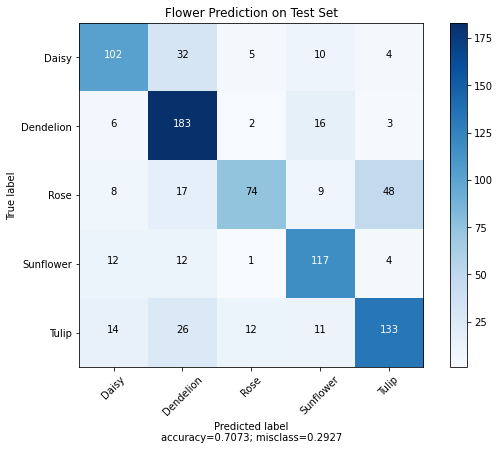

In [ ]:
plot_confusion_matrix(cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy(),  
                      normalize    = False,
                      target_names = ['Daisy', 'Dendelion', 'Rose', 'Sunflower', 'Tulip'],
                      title        = "Flower Prediction on Test Set")

In [ ]:
def target_translator (input_number) :
    
    if (input_number == 0) :
        return 'Daisy'
    
    elif (input_number == 1) :
        return 'Dendelion'
    
    elif (input_number == 2) :
        return 'Rose'
    
    elif (input_number == 3) :
        return 'Sunflower'
    
    elif (input_number == 4) :
        return 'Tulip'
    

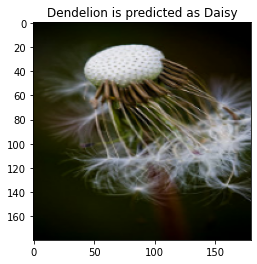

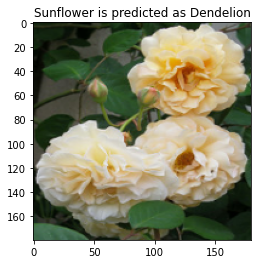

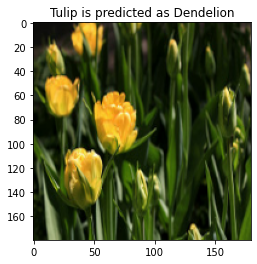

In [ ]:
breaker = 0


for counter in range (100) :
    if (true_labels[counter] != predicted_labels[counter]) :
        
        plt.title(target_translator(true_labels[counter]) + ' is predicted as ' + target_translator(predicted_labels[counter]))
        
        plt.imshow(images[counter].numpy().astype("uint8"))
        
        plt.show()
        
        breaker = breaker + 1
        
    if (breaker > 2) :
        break
